In [1]:
from pygam import LinearGAM, s, f

In [2]:
import dask.dataframe as ddf
import pandas as pd
import datetime
import functools
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
years = [year for year in range(2000, 2020)]
years

[2000,
 2001,
 2002,
 2003,
 2004,
 2005,
 2006,
 2007,
 2008,
 2009,
 2010,
 2011,
 2012,
 2013,
 2014,
 2015,
 2016,
 2017,
 2018,
 2019]

In [4]:
data = []
for year in years:
    suicide_year = pd.read_csv('/global/cfs/cdirs/m1532/Projects_MVP/geospatial/Suicide_Death_NCHS/suicide_patient_level_2000_2019/overall/overall_suicide_patient_level_' + str(year) + '.csv', dtype = {'year': int, 'county_residence': str, 'county_death': str, 'state_residence': str, 'state_death': str})
    suicide_year = suicide_year.loc[:, ~suicide_year.columns.str.contains('^Unnamed')]
    data.append(suicide_year)

In [5]:
suicide = pd.concat(data)
suicide.head()

,year,county_residence,state_residence,state_death,county_death,month,sex,race,age,age_range,death_cause
0,2000,01115,01,01,01055,Jan,Male,White,8,age 35-64,firearm_suicide
1,2000,01101,01,01,01101,Jan,Male,Black,4,age 15-34,firearm_suicide
2,2000,01001,01,01,01001,Jan,Female,White,6,age 35-64,firearm_suicide
3,2000,01003,01,01,01003,Jan,Female,White,3,age 0-14,nonfirearm_suicide
4,2000,01015,01,01,01015,Jan,Male,White,6,age 35-64,firearm_suicide


### Find daily suicide count

In [6]:
suicide_death = suicide.drop(['race', 'sex', 'age', 'county_residence', 'state_residence', 'state_death', 'county_death'], axis = 1)
suicide_death = suicide_death.groupby(['year', 'month', 'age_range']).count()
suicide_death = suicide_death.reset_index()
suicide_death = suicide_death.rename(columns = {'death_cause': 'deaths'})
suicide_death.head()

,year,month,age_range,deaths
0,2000,Apr,65 and older,471
1,2000,Apr,age 0-14,35
2,2000,Apr,age 15-34,714
3,2000,Apr,age 35-64,1265
4,2000,Aug,65 and older,498


In [7]:
suicide_death

,year,month,age_range,deaths
0,2000,Apr,65 and older,471
1,2000,Apr,age 0-14,35
2,2000,Apr,age 15-34,714
3,2000,Apr,age 35-64,1265
4,2000,Aug,65 and older,498
...,...,...,...,...
955,2019,Oct,age 35-64,1966
956,2019,Sep,65 and older,817
957,2019,Sep,age 0-14,42
958,2019,Sep,age 15-34,1211


In [8]:
month_replace = {'Jan': 1, 'Feb': 2, 'Mar': 3, 'Apr': 4, 'May': 5, 'Jun': 6, 'Jul': 7, 'Aug': 8, 'Sep': 9, 'Oct': 10,
                'Nov': 11, 'Dec': 12}
suicide_death['month'] = suicide_death['month'].replace(month_replace)
suicide_death['month'].unique()

array([ 4,  8, 12,  2,  1,  7,  6,  3,  5, 11, 10,  9])

#### when year == 1972, death = death * 2

In [9]:
summer_winter = [6, 7, 8, 12, 1, 2]
def is_summer_winter(month):
    if month in summer_winter :
        return 1
    else:
        return 0

In [10]:
suicide_death['summer_winter'] = suicide_death['month'].apply(is_summer_winter)
suicide_death.head()

,year,month,age_range,deaths,summer_winter
0,2000,4,65 and older,471,0
1,2000,4,age 0-14,35,0
2,2000,4,age 15-34,714,0
3,2000,4,age 35-64,1265,0
4,2000,8,65 and older,498,1


### Load monthly population data

In [11]:
years = [year for year in range(2000, 2020)]

In [12]:
pop_detailed = pd.read_csv("/global/cfs/cdirs/m1532/Projects_MVP/geospatial/temp_bins_suicide/Population/population_detailed_1969-2020.csv", dtype = {'fips': str})
pop_detailed = pop_detailed.loc[:, ~pop_detailed.columns.str.contains('^Unnamed')]
pop_detailed.head()

,year,state,fips,race,sex,age,pop
0,1969,AL,01001,white,Male,0 years,159
1,1969,AL,01001,white,Male,1-4 years,657
2,1969,AL,01001,white,Male,5-9 years,1137
3,1969,AL,01001,white,Male,10-14 years,956
4,1969,AL,01001,white,Male,15-19 years,721


In [13]:
pop_detailed['age'].unique()

array(['0 years', '1-4 years', '5-9 years', '10-14 years', '15-19 years',
       '20-24 years', '25-29 years', '30-34 years', '35-39 years',
       '40-44 years', '45-49 years', '50-54 years', '55-59 years',
       '60-64 years', '65-69 years', '70-74 years', '75-79 years',
       '80-84 years', 'over 85 years'], dtype=object)

In [14]:
age_0014 = ['0 years', '1-4 years', '5-9 years', '10-14 years']
age_1534 = ['15-19 years','20-24 years', '25-29 years', '30-34 years']
age_3564 = ['35-39 years', '40-44 years', '45-49 years', '50-54 years', '55-59 years','60-64 years']
age_over65 = ['65-69 years', '70-74 years', '75-79 years','80-84 years', 'over 85 years']

In [17]:
def findAgeRange(age):
    if age in age_0014:
        return 'age 0-14'
    elif age in age_1534:
        return 'age 15-34'
    elif age in age_3564:
        return 'age 35-64'
    else:
        return '65 and older'

In [18]:
pop_detailed['age_range'] = pop_detailed['age'].apply(findAgeRange)
pop_detailed.head()

,year,state,fips,race,sex,age,pop,age_range
0,1969,AL,01001,white,Male,0 years,159,age 0-14
1,1969,AL,01001,white,Male,1-4 years,657,age 0-14
2,1969,AL,01001,white,Male,5-9 years,1137,age 0-14
3,1969,AL,01001,white,Male,10-14 years,956,age 0-14
4,1969,AL,01001,white,Male,15-19 years,721,age 15-34


In [19]:
pop = pop_detailed.drop(['age', 'race', 'sex'], axis = 1)
pop = pop.rename(columns = {'age_range': 'age'})
pop.head()

,year,state,fips,pop,age
0,1969,AL,01001,159,age 0-14
1,1969,AL,01001,657,age 0-14
2,1969,AL,01001,1137,age 0-14
3,1969,AL,01001,956,age 0-14
4,1969,AL,01001,721,age 15-34


In [20]:
pop = pop.drop(['fips', 'state'], axis =1)
pop = pop.groupby(['year', 'age']).sum()
pop = pop.reset_index()
pop.head()

,year,age,pop
0,1969,65 and older,17794495
1,1969,age 0-14,52532602
2,1969,age 15-34,52361313
3,1969,age 35-64,58412671
4,1970,65 and older,18246757


In [21]:
suicide_death = suicide_death.rename(columns = {'age_range': 'age'})

In [22]:
suicide_pop = suicide_death.merge(pop, on = ['year', 'age'], how = 'inner')
suicide_pop.head()

,year,month,age,deaths,summer_winter,pop
0,2000,4,65 and older,471,0,31825455
1,2000,8,65 and older,498,1,31825455
2,2000,12,65 and older,343,1,31825455
3,2000,2,65 and older,376,1,31825455
4,2000,1,65 and older,465,1,31825455


In [23]:
suicide_pop['suicide_rate'] = (suicide_pop['deaths']/suicide_pop['pop'])*100000
suicide_pop.head()

,year,month,age,deaths,summer_winter,pop,suicide_rate
0,2000,4,65 and older,471,0,31825455,1.479947
1,2000,8,65 and older,498,1,31825455,1.564785
2,2000,12,65 and older,343,1,31825455,1.077754
3,2000,2,65 and older,376,1,31825455,1.181444
4,2000,1,65 and older,465,1,31825455,1.461095


In [24]:
suicide_pop['age'].unique()

array(['65 and older', 'age 0-14', 'age 15-34', 'age 35-64'], dtype=object)

### Load temperature and precipitation data from PRISM

In [25]:
years = [year for year in range(2000, 2020)]
years[40:]
data_temp = []
for year in years:
    temp_year = pd.read_csv('/global/cfs/cdirs/m1532/Projects_MVP/geospatial/PRISM_Data/PRISM_daily_county_level/prism_daily_county_level_' + str(year) + '.csv', dtype = {'year': int, 'fips': str})
    temp_year = temp_year.loc[:, ~temp_year.columns.str.contains('^Unnamed')]
    data_temp.append(temp_year)

In [26]:
climate = pd.concat(data_temp)
climate.head()

,fips,date,tMean,tMin,tMax,prec,year
0,01001,2000-01-01,16.262459,10.089380,22.435537,0.560423,2000
1,01001,2000-01-02,17.412651,11.954220,22.871081,0.390251,2000
2,01001,2000-01-03,18.705264,14.001039,23.409490,0.216170,2000
3,01001,2000-01-04,16.203456,9.861904,22.545009,16.488676,2000
4,01001,2000-01-05,6.494604,-1.153744,14.142953,0.216055,2000


In [27]:
def celsius_to_fahrenheit(celsius):
    return (celsius * 9/5) + 32

In [28]:
climate['tMean'] = climate['tMean'].apply(celsius_to_fahrenheit)
climate['tMin'] = climate['tMin'].apply(celsius_to_fahrenheit)
climate['tMax'] = climate['tMax'].apply(celsius_to_fahrenheit)

In [29]:
import datetime

In [30]:
def convertTime(time):
    return datetime.strptime(time, '%Y-%m-%d')

In [31]:
def getMonth(date):
    return(date.strftime('%b'))

In [32]:
climate['date'] = pd.to_datetime(climate['date'])
climate['month'] = climate['date'].apply(getMonth)

In [33]:
climate.head()

,fips,date,tMean,tMin,tMax,prec,year,month
0,01001,2000-01-01,61.272425,50.160884,72.383967,0.560423,2000,Jan
1,01001,2000-01-02,63.342771,53.517596,73.167946,0.390251,2000,Jan
2,01001,2000-01-03,65.669476,57.201870,74.137082,0.216170,2000,Jan
3,01001,2000-01-04,61.166221,49.751427,72.581016,16.488676,2000,Jan
4,01001,2000-01-05,43.690288,29.923261,57.457315,0.216055,2000,Jan


In [34]:
month_replace = {'Jan': 1, 'Feb': 2, 'Mar': 3, 'Apr': 4, 'May': 5, 'Jun': 6, 'Jul': 7, 'Aug': 8, 
                 'Sep': 9, 'Oct': 10, 'Nov': 11, 'Dec': 12}
climate['month'] = climate['month'].replace(month_replace)
climate.head()

,fips,date,tMean,tMin,tMax,prec,year,month
0,01001,2000-01-01,61.272425,50.160884,72.383967,0.560423,2000,1
1,01001,2000-01-02,63.342771,53.517596,73.167946,0.390251,2000,1
2,01001,2000-01-03,65.669476,57.201870,74.137082,0.216170,2000,1
3,01001,2000-01-04,61.166221,49.751427,72.581016,16.488676,2000,1
4,01001,2000-01-05,43.690288,29.923261,57.457315,0.216055,2000,1


In [35]:
climate = climate.drop(['fips', 'date'], axis = 1)
climate = climate.groupby(['year', 'month']).mean()
climate = climate.reset_index()
climate.head()

,year,month,tMean,tMin,tMax,prec
0,2000,1,33.699767,22.991576,44.407958,2.214460
1,2000,2,40.700009,28.945989,52.454030,2.164661
2,2000,3,48.228999,35.979568,60.478429,2.588274
3,2000,4,53.376460,40.754625,65.998294,2.785087
4,2000,5,65.413321,53.298932,77.527709,2.954953


In [36]:
suicide_climate = suicide_pop.merge(climate, on = ['year', 'month'], how = 'inner')
suicide_climate.head()

,year,month,age,deaths,summer_winter,pop,suicide_rate,tMean,tMin,tMax,prec
0,2000,4,65 and older,471,0,31825455,1.479947,53.376460,40.754625,65.998294,2.785087
1,2000,4,age 0-14,35,0,54443539,0.064287,53.376460,40.754625,65.998294,2.785087
2,2000,4,age 15-34,714,0,72194193,0.988999,53.376460,40.754625,65.998294,2.785087
3,2000,4,age 35-64,1265,0,97803290,1.293413,53.376460,40.754625,65.998294,2.785087
4,2000,8,65 and older,498,1,31825455,1.564785,75.156451,63.039548,87.273353,2.242387


In [37]:
suicide_climate['summer_winter'].unique()

array([0, 1])

### Apply GAM model

In [38]:
from pygam import LinearGAM, s, f
import pandas as pd
from sklearn.metrics import mean_squared_error
from math import log

In [39]:
suicide_climate.to_csv('monthly_GAM_age_group_final.csv')

In [30]:
suicide_0024 = suicide_climate[suicide_climate['age'] == 'age 0-24']
suicide_2564 = suicide_climate[suicide_climate['age'] == 'age 25-64']
suicide_over65 = suicide_climate[suicide_climate['age'] == '65 and older']

In [31]:
import numpy as np

In [32]:
def perform_model(df, data_type):
    X = df[['tMean', 'prec', 'month', 'summer_winter']]
    y = df['suicide_rate']
    model = LinearGAM(s(0, n_splines=6) + s(1, n_splines=6) + s(2, n_splines=12) + f(3))
    model.fit(X, y)
    feature_names = ['Monthly Mean Temperature', 'Precipitation', 'Month', 'Summer_Winter']
    titles = [f'Partial Dependence for {name}' for name in feature_names]
    x_labels = ['Monthly Mean Temperature (°F)', 'Precipitation (inch)', 'Month', 'Summer_Winter']

    # Plotting the partial dependence for each feature
    for i, term in enumerate(model.terms):
        if term.isintercept:
            continue

        XX = model.generate_X_grid(term=i)
        pdep, confi = model.partial_dependence(term=i, X=XX, width=0.95)

        plt.figure()
        plt.plot(XX[:, i], pdep)
        plt.plot(XX[:, i], confi, c='r', ls='--')
        # Use the feature names for the title instead of feature index
        plt.title(titles[i])
        plt.xlabel(x_labels[i])
        plt.ylabel('Effect on Monthly Suicide Rate ' + '(' + data_type + ')')
        plt.show()
        
    delta = 1  # small change in the feature
    # Assuming X is a pandas DataFrame
    X_new = X.copy()
    X_new.iloc[:, 0] += delta  # Use .iloc to increment all values in the first column
    marginal_effect = (model.predict(X_new) - model.predict(X)) / delta
    # X_baseline = X.mean().to_frame().T  
    # baseline_risk = model.predict(X_baseline)[0] 
    # print("the baseline risk is " + str(baseline_risk))
    baseline_risk = 0.9590918381239725
    ORs = np.exp(marginal_effect)
    RRs = ORs / ((1 - baseline_risk) + (baseline_risk * ORs))
    temperatures = df['tMean']
    # Now plot RRs against temperatures
    plt.figure(figsize=(10, 6))
    plt.plot(temperatures, RRs, label='RR of Temperature')
    plt.xlabel('Monthly Mean Temperature (°F)')
    plt.ylabel('Relative Risk')
    plt.title('Relative Risk for Monthly Mean Temperature ' + '(' + data_type + ')')
    plt.legend()
    plt.show()
    
    from sklearn.metrics import mean_squared_error
    mse = mean_squared_error(y, model.predict(X))
    print("MSE is " + str(mse))

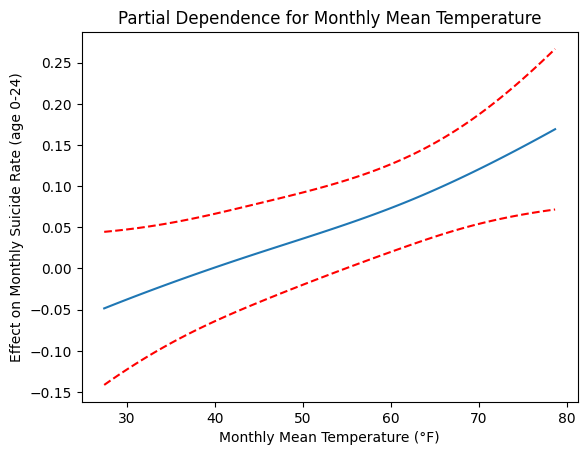

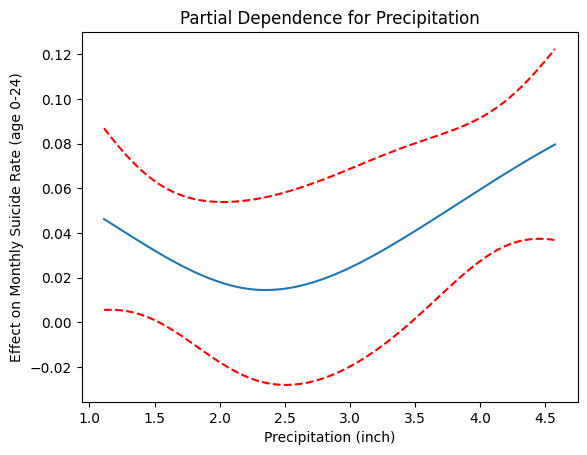

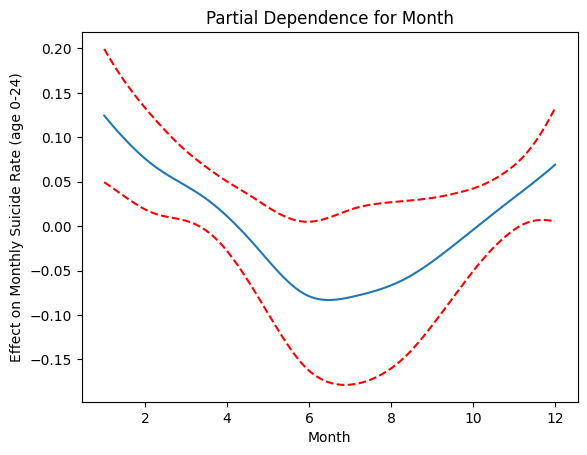

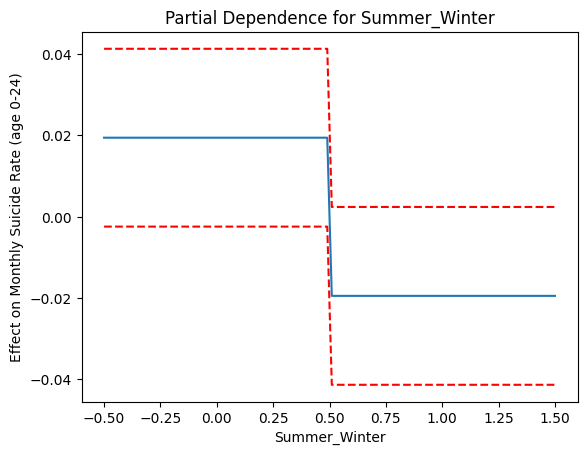

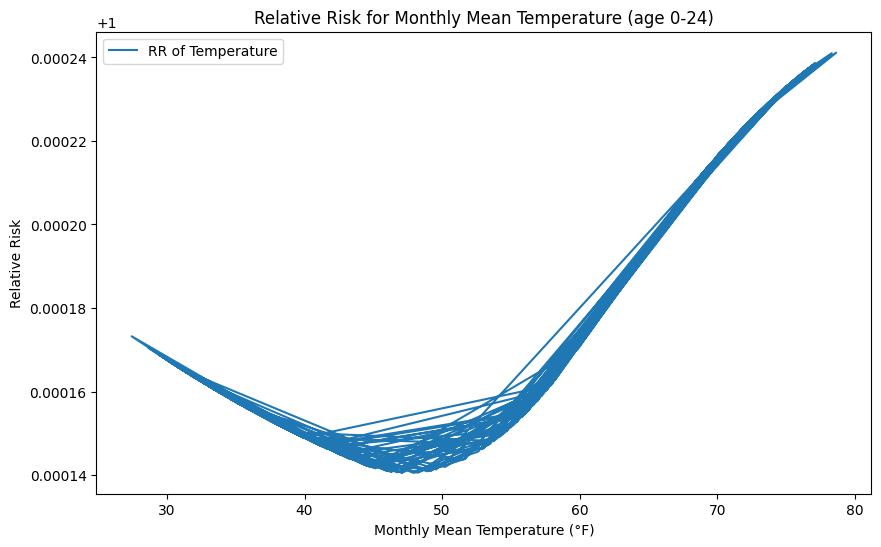

MSE is 0.0058182980943108946


In [33]:
perform_model(suicide_0024, 'age 0-24')

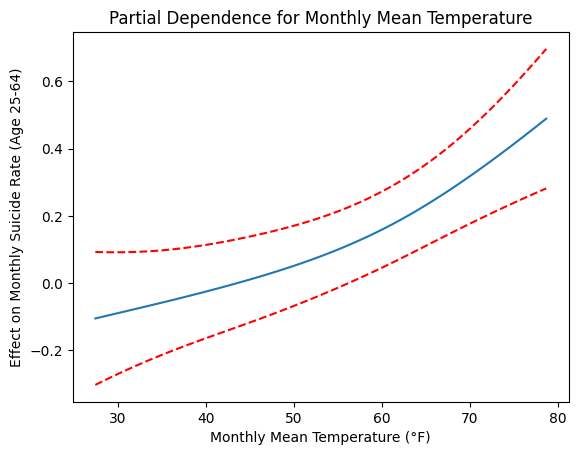

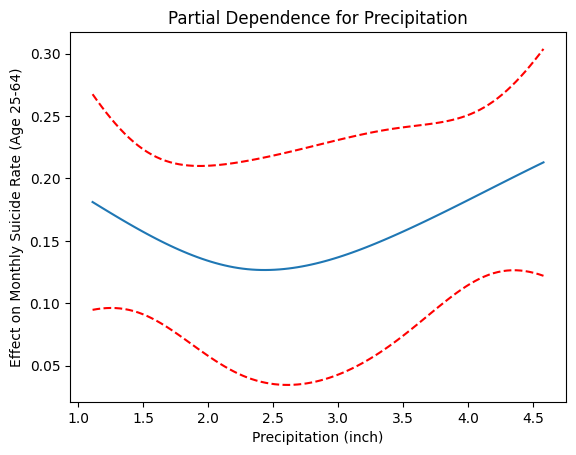

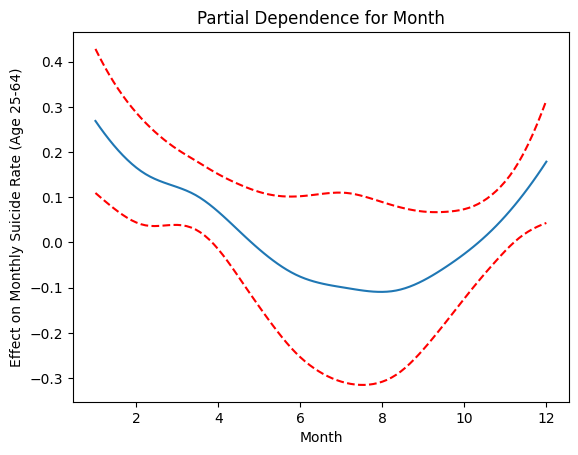

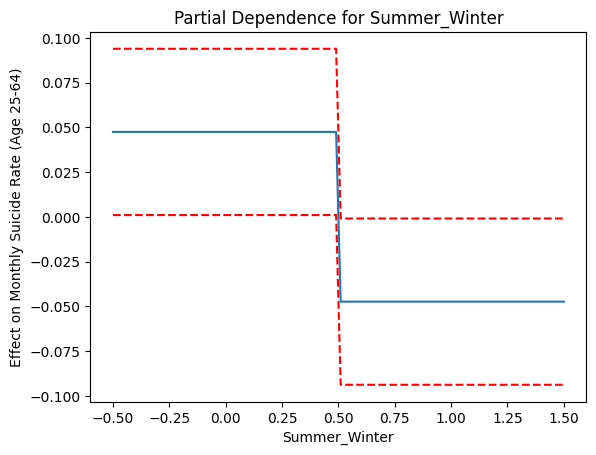

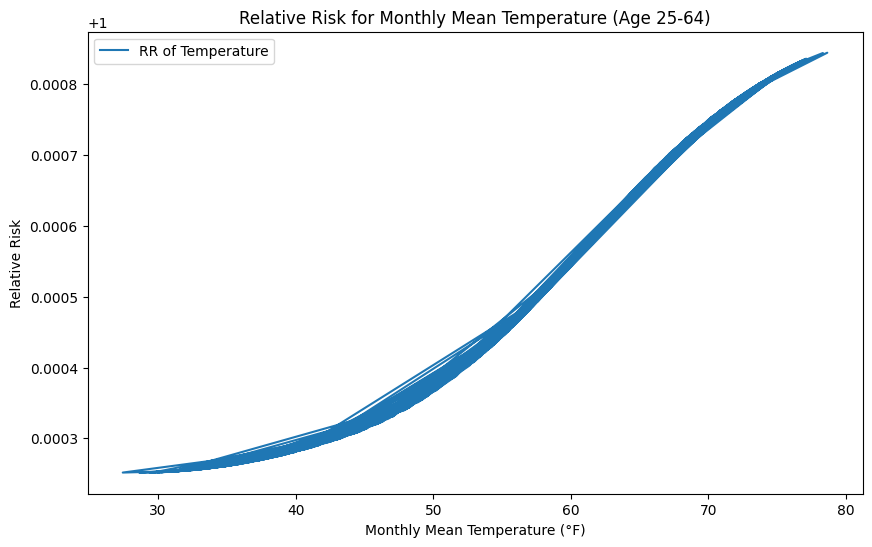

MSE is 0.02628339823316541


In [34]:
perform_model(suicide_2564, 'Age 25-64')

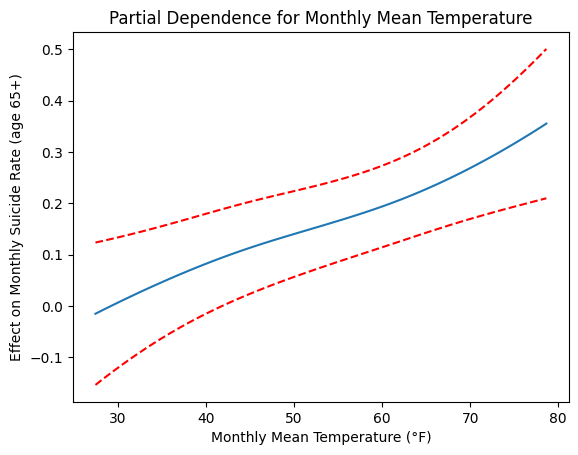

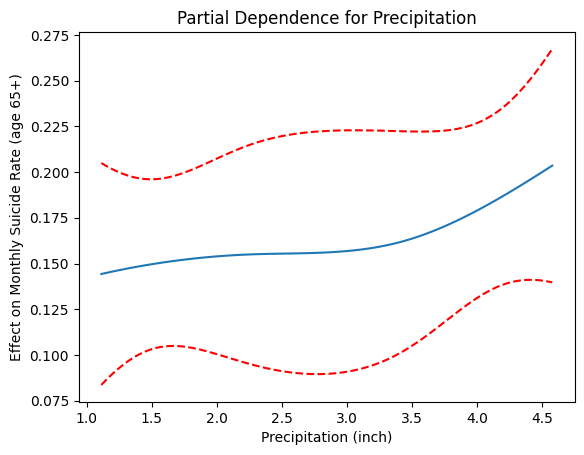

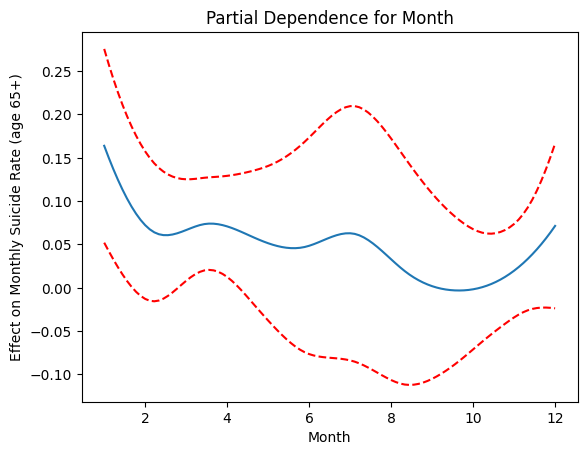

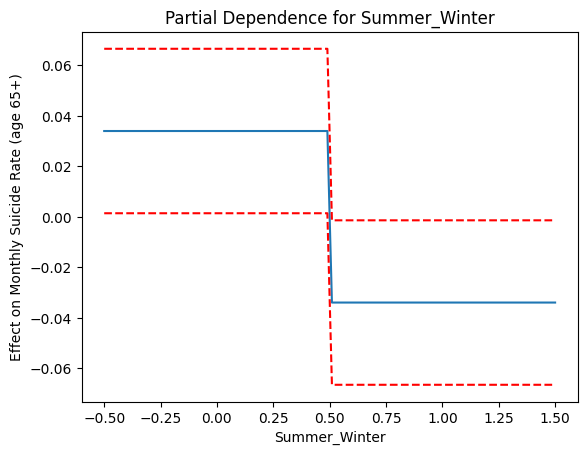

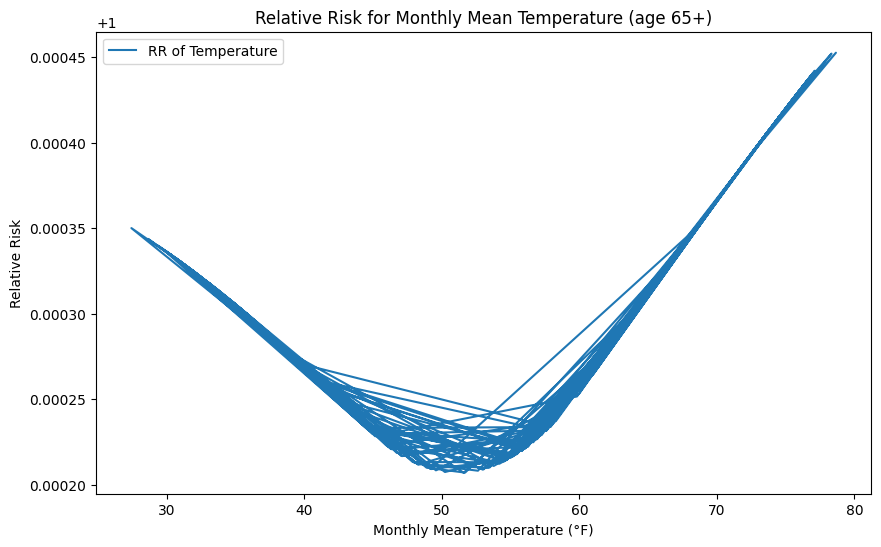

MSE is 0.012929395717070613


In [35]:
perform_model(suicide_over65, 'age 65+')

### Use poisson regression method to check the relative risk

In [37]:
import statsmodels.api as sm

In [38]:
def calculate_RR(df, data_type):
    # Assuming 'data' is your DataFrame and contains 'suicide_count', 'temperature', 'precipitation', and 'population'
    X = df[['tMean', 'prec']]  # Predictor variables
    y = df['deaths']  # Response variable: count of suicides

    # Add a constant to the model (intercept)
    X = sm.add_constant(X)

    # Include the log of population as an offset
    offset = np.log(df['pop'])

    # Fit the Poisson regression model
    poisson_model = sm.GLM(y, X, offset=offset, family=sm.families.Poisson()).fit()

    # Get the summary of the model
    print(poisson_model.summary())

    # Calculate the relative risk for a one-unit increase in temperature
    RR_temperature = np.exp(poisson_model.params['tMean'])
    print('relative risk of monthly ' + ' suicide rate by temperature is '  + str(RR_temperature) + ' for ' + data_type)
    conf_int = poisson_model.conf_int().loc['tMean']
    RR_CI_lower, RR_CI_upper = np.exp(conf_int)
    print(f"The 95% CI for the RR of temperature is: ({RR_CI_lower}, {RR_CI_upper})")

In [39]:
calculate_RR(suicide_0024, 'Age 0-24')

                 Generalized Linear Model Regression Results                  
Dep. Variable:                 deaths   No. Observations:                  240
Model:                            GLM   Df Residuals:                      237
Model Family:                 Poisson   Df Model:                            2
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -2474.9
Date:                Wed, 07 Feb 2024   Deviance:                       3059.1
Time:                        12:15:28   Pearson chi2:                 3.18e+03
No. Iterations:                     4   Pseudo R-squ. (CS):            0.09769
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        -12.3769      0.015   -828.407      0.0

In [40]:
calculate_RR(suicide_2564, 'Age 25-64')

                 Generalized Linear Model Regression Results                  
Dep. Variable:                 deaths   No. Observations:                  240
Model:                            GLM   Df Residuals:                      237
Model Family:                 Poisson   Df Model:                            2
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -4396.6
Date:                Wed, 07 Feb 2024   Deviance:                       6506.5
Time:                        12:15:28   Pearson chi2:                 6.47e+03
No. Iterations:                     4   Pseudo R-squ. (CS):             0.9901
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        -11.2800      0.007  -1708.499      0.0

In [41]:
calculate_RR(suicide_over65, 'Age 65+')

                 Generalized Linear Model Regression Results                  
Dep. Variable:                 deaths   No. Observations:                  240
Model:                            GLM   Df Residuals:                      237
Model Family:                 Poisson   Df Model:                            2
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -1446.4
Date:                Wed, 07 Feb 2024   Deviance:                       943.80
Time:                        12:15:30   Pearson chi2:                     950.
No. Iterations:                     4   Pseudo R-squ. (CS):             0.8508
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        -11.3786      0.013   -856.164      0.0

### Check the suicide rates in each season

In [42]:
suicide_climate

,year,month,age,deaths,summer_winter,pop,suicide_rate,tMean,tMin,tMax,prec
0,2000,1,65 and older,465,1,31825455,1.461095,33.699767,22.991576,44.407958,2.214460
1,2000,1,age 0-24,397,1,90056927,0.440832,33.699767,22.991576,44.407958,2.214460
2,2000,1,age 25-64,1736,1,134384095,1.291820,33.699767,22.991576,44.407958,2.214460
3,2000,2,65 and older,376,1,31825455,1.181444,40.700009,28.945989,52.454030,2.164661
4,2000,2,age 0-24,378,1,90056927,0.419735,40.700009,28.945989,52.454030,2.164661
...,...,...,...,...,...,...,...,...,...,...,...
715,2019,11,age 0-24,519,0,93529202,0.554907,41.660884,30.582931,52.738837,1.816941
716,2019,11,age 25-64,2421,0,155096538,1.560963,41.660884,30.582931,52.738837,1.816941
717,2019,12,65 and older,711,1,49283871,1.442663,38.711947,28.725012,48.698881,2.417830
718,2019,12,age 0-24,519,1,93529202,0.554907,38.711947,28.725012,48.698881,2.417830


In [43]:
spring = [3, 4, 5]
summer = [6, 7, 8]
fall = [9, 10, 11]
winter = [12, 1, 2]
def findSeason(month):
    if month in spring:
        return 'Spring'
    elif month in summer:
        return 'Summer'
    elif month in fall:
        return 'Fall'
    else:
        return 'Winter'

In [44]:
suicide_climate['season'] = suicide_climate['month'].apply(findSeason)
suicide_climate

,year,month,age,deaths,summer_winter,pop,suicide_rate,tMean,tMin,tMax,prec,season
0,2000,1,65 and older,465,1,31825455,1.461095,33.699767,22.991576,44.407958,2.214460,Winter
1,2000,1,age 0-24,397,1,90056927,0.440832,33.699767,22.991576,44.407958,2.214460,Winter
2,2000,1,age 25-64,1736,1,134384095,1.291820,33.699767,22.991576,44.407958,2.214460,Winter
3,2000,2,65 and older,376,1,31825455,1.181444,40.700009,28.945989,52.454030,2.164661,Winter
4,2000,2,age 0-24,378,1,90056927,0.419735,40.700009,28.945989,52.454030,2.164661,Winter
...,...,...,...,...,...,...,...,...,...,...,...,...
715,2019,11,age 0-24,519,0,93529202,0.554907,41.660884,30.582931,52.738837,1.816941,Fall
716,2019,11,age 25-64,2421,0,155096538,1.560963,41.660884,30.582931,52.738837,1.816941,Fall
717,2019,12,65 and older,711,1,49283871,1.442663,38.711947,28.725012,48.698881,2.417830,Winter
718,2019,12,age 0-24,519,1,93529202,0.554907,38.711947,28.725012,48.698881,2.417830,Winter


In [45]:
suicide_death_season = suicide_climate[['year', 'season', 'deaths', 'age']]
suicide_death_season = suicide_death_season.groupby(['year', 'season', 'age']).sum()
suicide_death_season = suicide_death_season.reset_index()
suicide_death_season.head()

,year,season,age,deaths
0,2000,Fall,65 and older,1271
1,2000,Fall,age 0-24,1088
2,2000,Fall,age 25-64,4745
3,2000,Spring,65 and older,1412
4,2000,Spring,age 0-24,1105


In [46]:
suicide_pop_season = suicide_climate[['year', 'season', 'pop', 'age']]
suicide_pop_season = suicide_pop_season.groupby(['year', 'season', 'age']).mean()
suicide_pop_season = suicide_pop_season.reset_index()
suicide_pop_season.head()

,year,season,age,pop
0,2000,Fall,65 and older,31825455.0
1,2000,Fall,age 0-24,90056927.0
2,2000,Fall,age 25-64,134384095.0
3,2000,Spring,65 and older,31825455.0
4,2000,Spring,age 0-24,90056927.0


In [47]:
suicide_season = suicide_death_season.merge(suicide_pop_season, on = ['year', 'season', 'age'], how = 'inner')
suicide_season['suicide_rate'] = (suicide_season['deaths']/suicide_season['pop'])*100000
suicide_season.head()

,year,season,age,deaths,pop,suicide_rate
0,2000,Fall,65 and older,1271,31825455.0,3.993659
1,2000,Fall,age 0-24,1088,90056927.0,1.208125
2,2000,Fall,age 25-64,4745,134384095.0,3.530924
3,2000,Spring,65 and older,1412,31825455.0,4.436700
4,2000,Spring,age 0-24,1105,90056927.0,1.227002


In [48]:
suicide_season_0024 = suicide_season[suicide_season['age'] == 'age 0-24']
suicide_season_2564 = suicide_season[suicide_season['age'] == 'age 25-64']
suicide_season_over65 = suicide_season[suicide_season['age'] == '65 and older']

In [49]:
import matplotlib.pyplot as plt
import seaborn as sns

In [50]:
def plot_seasonal_suicide(df, data_type):
    # Plotting
    plt.figure(figsize=(15, 6))  # Adjust the size as needed
    sns.lineplot(x='year', y='suicide_rate', hue='season', data= df, palette='muted', marker='o')

    plt.title('Seasonal Suicide Rates from 1970 to 2019 by Season ' + '(' + data_type + ')')
    plt.xlabel('Year')
    plt.ylabel('Suicide Rate')
    plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
    plt.legend(title='Season')

    plt.tight_layout()
    plt.show()

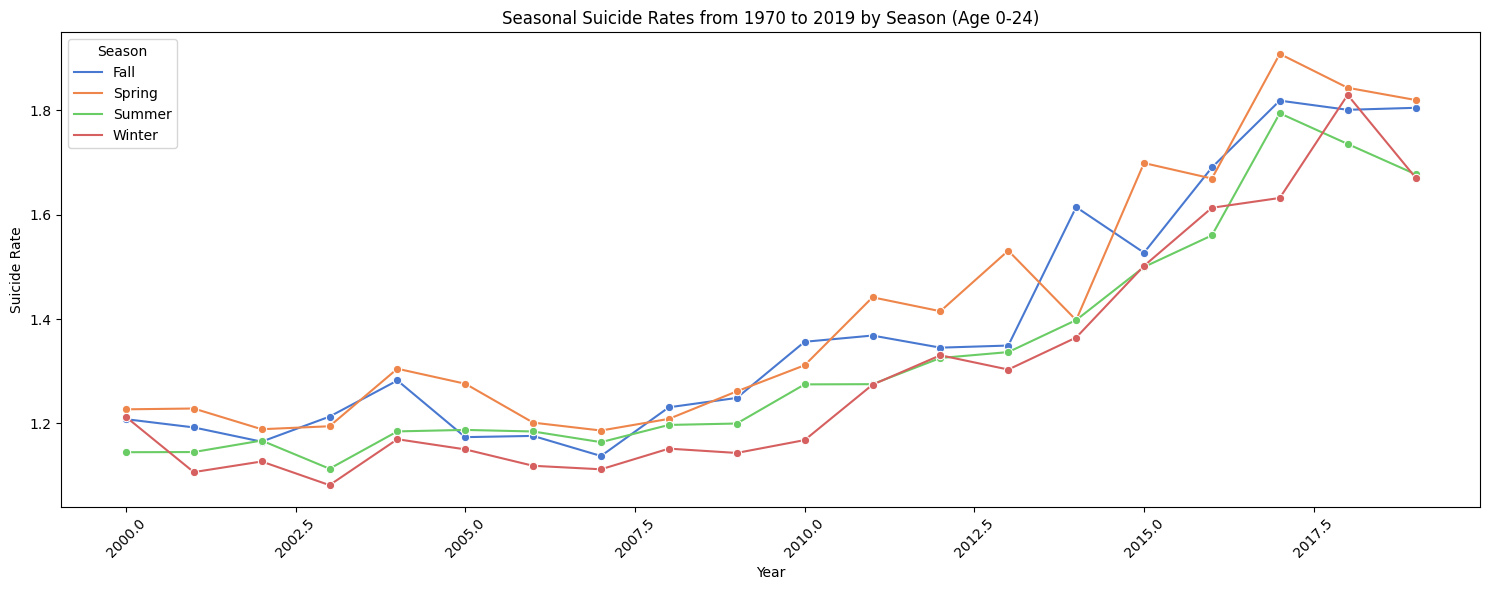

In [51]:
plot_seasonal_suicide(suicide_season_0024, 'Age 0-24')

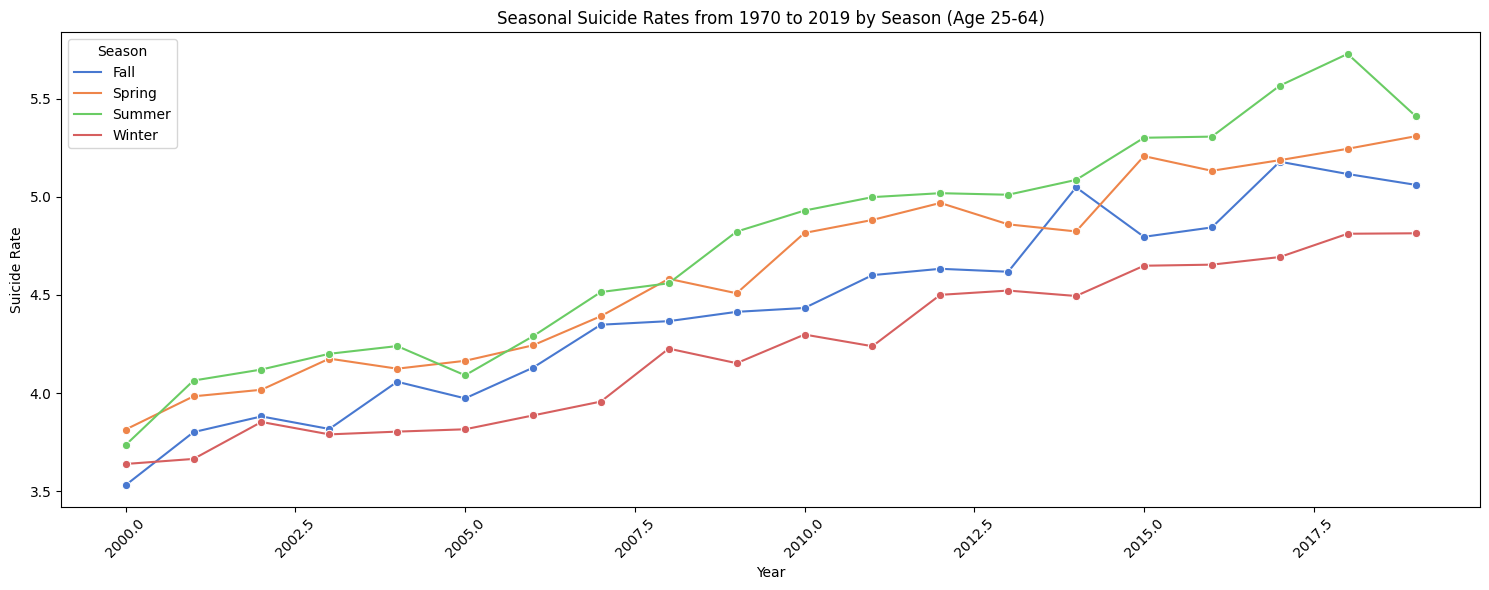

In [52]:
plot_seasonal_suicide(suicide_season_2564, 'Age 25-64')

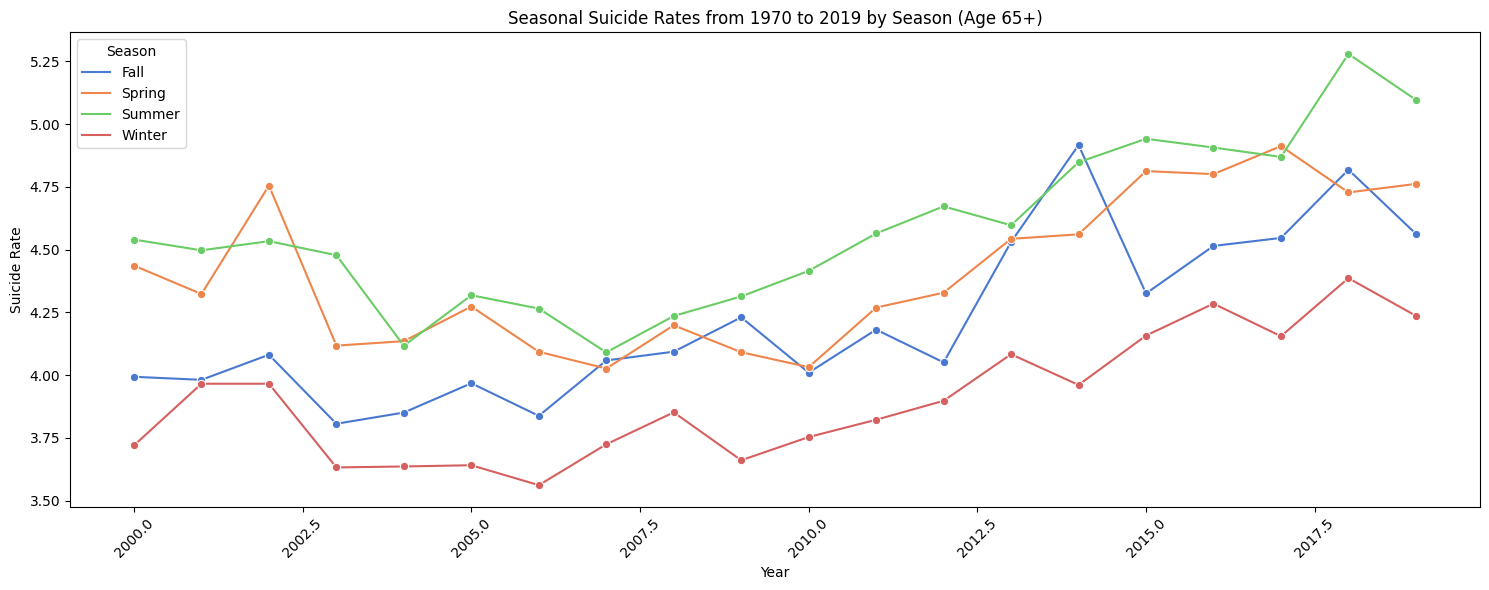

In [53]:
plot_seasonal_suicide(suicide_season_over65, 'Age 65+')